## Analysis Steps
### 1: Retrieve datasets
- Cleaveland Crime Incidents (https://la.arcgis.com/databrowser/index.html)
- American Community Survey data (https://www.census.gov/acs/www/data/data-tables-and-tools/data-profiles/2022/)
### 2 Geoenrichment
- Combine the datasets via geoenrichment (per census tract, per year)
### 3 Initial Visualizations
- Perform hotspot analysis to locate areas of high incident crime rates in Cleveland
- Choropleth maps to understand distribution of Census variables
    - Compare demographic differences over time
### 4 Correlation Analysis
- Compare our visualizations to locate any clearly visible trends
- Perform a correlation analysis on socioeconomic/demographic factors and how they may explain variability in crime rates.
### 5 Test ML Models
- Try a variety of Machine Learning models to see how we may be able to predict crime rates or areas of crime based on our selected factors
    - Split into a training vs test set (80/20). See which ones have the lowest MSE.
    - kNN, Isolation Forest, One-class SVM, Random Forest
    - Compare models and select the best


## Imports

In [ ]:
# imports
import pandas as pd
import geopandas as gpd
import numpy as np
import os
import imageio

import censusdata
from census import Census
from us import states

from matplotlib import pyplot as plt
import pygris
import folium

import arcgis
from arcgis.gis import GIS
from arcgis import geometry
from arcgis.geometry import Geometry, SpatialReference
from arcgis.features import FeatureLayer
from arcgis.features.analyze_patterns import find_hot_spots

from IPython.display import Image

pd.set_option('display.max_columns', None)

In [ ]:
gis=GIS("https://ucsdonline.maps.arcgis.com/home", client_id="lDqkROmmIfqeDoXQ") 

## Part 0: Imports and Initialization

### Functions

In [ ]:

def download_OH_data(var_map, year_start, year_end):
    df_final = None
    
    for yr in range(year_start, year_end + 1):
        c = Census("4977648d549eae5dd6bc0563b7c148db6c44642d", year=yr)
        
        for raw_var, alias in var_map.items():
  
            if raw_var.startswith('DP'):
                data = c.acs5dp.get(
                    ('NAME', raw_var),
                    {'for': 'tract:*', 'in': f'state:{states.OH.fips} county:035'}
                )
            else:
                data = c.acs5.get(
                    ('NAME', raw_var),
                    {'for': 'tract:*', 'in': f'state:{states.OH.fips} county:035'}
                )
            

            df_temp = pd.DataFrame(data)
            df_temp.rename(columns={raw_var: f"{alias}_{yr}"}, inplace=True)

            # Merge it into df_final
            if df_final is None:
                # If this is the first chunk of data, just assign
                df_final = df_temp
            else:
                # Otherwise, merge on the geo-id columns
                df_final = pd.merge(
                    df_final, df_temp,
                    on=['NAME', 'state', 'county', 'tract'],
                    how='outer'  # or 'inner', your choice
                )
                
    return df_final

def split_df_by_year(df):
    # dict of years with lists of sets of column_name without years and column_name with years
    year_cols = {}
    for col in df.columns:
        parts = col.split('_')
        if len(parts) > 1 and parts[-1].isdigit() and len(parts[-1]) == 4:
            year = parts[-1]
            base_name = '_'.join(parts[:-1])
            if year not in year_cols:
                year_cols[year] = []
            year_cols[year].append((base_name, col))

    dfs = {}
    for year, cols in year_cols.items():
        new_df = df[['NAME', 'state', 'county', 'tract']].copy() 
        new_df['year'] = year
        for base_name, col in cols:
            new_df[base_name] = df[col]
        dfs[year] = new_df

    return dfs


## Part 1: Getting Data

### Census Data

- Using the `censusdata` API, we are using the search functionality to locate variables under certain categories that we expect to have correlation with crime rates

In [ ]:
s = censusdata.search('acs5', 2015, 'label', 'family')
# s

Census variables we are considering:
- Level of income
- Type of household structure
- Educational attainment
- GINI Index (measure of inequality)
<br></br>
Not yet implimented
- Population counts by age ranges
- Immigration/emmigration (how many people are moving from/to some area)
- Housing information (proportion of renters/owners, family size)

In [ ]:
'''
TODO: Finish age dist. variables, combine into smaller groups
   # AGE DISTRIBUTION VARIABLES
   'B01001_003E': 'age_male_0_4',
   'B01001_004E': 'age_male_5_9',
   'B01001_005E': 'age_male_10_14',
   'B01001_006E': 'age_male_15_17',
   'B01001_007E': 'age_male_18_19',
   'B01001_008E': 'age_male_20',
   'B01001_009E': 'age_male_21',
   'B01001_010E': 'age_male_22_24',
   'B01001_011E': 'age_male_25_29',
   'B01001_012E': 'age_male_30_34',
   'B01001_013E': 'age_male_35_39',
   'B01001_014E': 'age_male_40_44',
   'B01001_015E': 'age_male_45_49',
   'B01001_016E': 'age_male_50_54',
   'B01001_017E': 'age_male_55_59',
   'B01001_018E': 'age_male_60_61',
   'B01001_019E': 'age_male_62_64',
   'B01001_020E': 'age
'''

'''
Add. codes to find:
 - Immigration/emmigration (how many people are moving to/from the area?)
    - mobility/migration
 - Housing information (how many people own/rent their homes?)
'''
codes = {
   # INCOME VARIABLES
   'B06010_003E': 'income_yes',
   'B06010_004E': 'income_no',
   'B06010_005E': 'income_0_10k',
   'B06010_006E': 'income_10_25k',
   'B06010_007E': 'income_25_35k',
   'B06010_008E': 'income_35_45k',
   'B06010_009E': 'income_45_55k',
   'B06010_010E': 'income_55_65k',
   'B06010_011E': 'income_65_75k',
   'B06010_013E': 'income_over_75k',
   'B06002_001E': 'median_age',
   # EDUCATION VARIABLES
   'B15003_017E': 'edu_highschool',
   'B15003_018E': 'edu_ged',
   'B15003_021E': 'edu_associates',
   'B15003_022E': 'edu_bachelors',
   'B15003_023E': 'edu_masters',
   'B15003_024E': 'edu_professional',
   'B15003_025E': 'edu_doctorate',

   #FAMILY STRUCTURE VARIABLES
   'B11001_003E': 'household_fam_married_couple',
   'B11001_004E': 'household_fam_other',
   'B11001_005E': 'household_fam_male',
   'B11001_006E': 'household_fam_female',
   'B11001_008E': 'household_nonfam_alone',
   'B11001_009E': 'household_nonfam_not_alone',

   # Measure of index inequality
   'B19083_001E': 'gini_index'
}

- Using the `censusdata` API, we outlined several functions to download data from the 5-year American Community Survey for our range of variables.

In [ ]:
df_2010 = download_OH_data(codes, 2015, 2019)

In [ ]:
dfs_2010 = split_df_by_year(df_2010)
final_df_2010 = pd.concat(dfs_2010.values(), ignore_index=True)

- We use `pygris` to access geometries for the census tracts and combine this with our downloaded data

In [ ]:
tracts_2010 = pygris.tracts(state="39", county="035", year=2015)
tracts_2020 = pygris.tracts(state="39", county="035", year=2020)

# Drop the tract containing Lake Erie for better plotting
# I'm pretty sure this doesn't matter anyways??
tracts_2010 = tracts_2010.drop(index=680).reset_index(drop=True)[['TRACTCE','geometry']]
tracts_2020 = tracts_2020.drop(index=308).reset_index(drop=True)[['TRACTCE','geometry']]

In [ ]:
# final_df_2010 = final_df_2010.merge(tracts_2010, left_on='tract', right_on='TRACTCE', how='left').drop(columns=['TRACTCE'])
# final_df_2010 = gpd.GeoDataFrame(final_df_2010, geometry='geometry', crs="EPSG:4269")

In [ ]:
'''
TODO: we need to find a way to merge our data between the two different censuses.
Because the tracts are different across 2010 and 2020 we cannot simply combine them
This tool can be used to visually see differences.
https://www.robots.ox.ac.uk/~vgg/software/image-compare/app/latest/
'''
# tract_rel_df = pd.read_csv('./data/2010tract_to_2020_tract_relationships.txt', delimiter='|', dtype=str)
# tract_rel_df.head()

## Crime Incidents Data

In [ ]:
# we take the original crime data and use filters within mapviewer to create this new feature layer
url = 'https://services3.arcgis.com/dty2kHktVXHrqO8i/arcgis/rest/services/Crime_Incidents/FeatureServer/0'
layer = FeatureLayer(url)
crime_sdf = layer.query(where="OffenseYear >= 2015 AND OffenseYear <= 2021 AND CENSUS_TRACT <> 'Not Located' and UCRdesc IN ('Assault', 'Theft', 'Burglary', 'Robbery', 'Rape', 'Arson', 'Weapons', 'Homicide')", out_fields="*", as_df=True)
# udeally we would like to save it to ArcGIS, but we can't :(
crime_sdf.head()

In [ ]:
Image(filename='data/total_crime_in_cleveland.png')
# There is way too much crime between 2015 and 2021, including all types of crime (750,000 records)

In [ ]:
# Therefore, we will limit it to just "assault", "theft", "burglary", "robbery", "rape", "arson", "weapons", "homicide", which are violent crimes
# This cuts down the records to 230,000
Image(filename='data/violent_crime_in_cleveland.png')

## Cleveland City Boundaries

In [ ]:
city_url = "https://services3.arcgis.com/dty2kHktVXHrqO8i/arcgis/rest/services/City_Boundary/FeatureServer/0/"
city_boundary = FeatureLayer(city_url)

In [ ]:
cleveland_map = gis.map("Cleveland, Ohio")
cleveland_map

In [ ]:
cleveland_map.content.add(city_boundary)

## Part 2: Preprocessing and Combining Data

## Part 3: Visualizations

- VERY IMPORTANT: THE CENSUS TRACTS CHANGE IN QUANTITY AND BOUNDARY STARTING IN 2020
- We can use the relationship file provided below to figure out these differences
https://www.census.gov/geographies/reference-files/time-series/geo/relationship-files.2020.html

In [ ]:
# skip_cols = ['NAME', 'state', 'county', 'tract', 'year', 'geometry']
# # Create a dictionary mapping each column to its (min, max) across the dataset
# column_ranges = {}
# for col in final_df_2010.columns:
#     if col in skip_cols:
#         continue
#     col_min = final_df_2010[col].min()
#     col_max = final_df_2010[col].max()
#     column_ranges[col] = (col_min, col_max)

# output_dir = "maps"
# os.makedirs(output_dir, exist_ok=True)

# unique_years = sorted(final_df_2010['year'].unique())

# for col in final_df_2010.columns:
#     if col in skip_cols:
#         continue
#     # Make a subfolder for each column to store yearly maps
#     col_dir = os.path.join(output_dir, col)
#     os.makedirs(col_dir, exist_ok=True)
    
#     vmin, vmax = column_ranges[col]
    
#     for yr in unique_years:
#         df_year = final_df_2010[final_df_2010['year'] == yr]
        
#         fig, ax = plt.subplots(1, 1, figsize=(8, 8))
        
#         # Choropleth plot, specifying a consistent color range
#         df_year.plot(
#             column = col,  # <-- numeric column for coloring
#             legend = True,          # shows color bar legend
#             figsize = (10, 10),     # size of the figure
#             cmap = "plasma",        # color map
#             legend_kwds = {"shrink": 0.5},     # shrink legend if needed
#             missing_kwds = {"color": "lightgrey"},  # color for NaN or missing geometry
#             ax=ax,
#             vmin=vmin,
#             vmax=vmax,
#         )

#         # Set color limits
#         sm = plt.cm.ScalarMappable(cmap="plasma", norm=plt.Normalize(vmin=vmin, vmax=vmax))
#         sm._A = []
#         cbar = fig.colorbar(sm, ax=ax)
        
#         ax.set_title(f"{col} in {yr}")
#         ax.axis('off')
        
#         # Save the figure
#         outpath = os.path.join(col_dir, f"{col}_{yr}.png")
#         plt.savefig(outpath, bbox_inches='tight', dpi=150)
#         plt.close(fig)

# for col in final_df_2010.columns:
#     if col in skip_cols:
#         continue
#     col_dir = os.path.join(output_dir, col)
#     # Sort the file names by year
#     frames = []
#     for yr in unique_years:
#         filename = f"{col}_{yr}.png"
#         filepath = os.path.join(col_dir, filename)
#         frames.append(imageio.imread(filepath))

#     # Create the GIF
#     gif_path = os.path.join(output_dir, f"{col}.gif")
#     imageio.mimsave(gif_path, frames, duration=2.0,loop=0)  # 1 second per frame

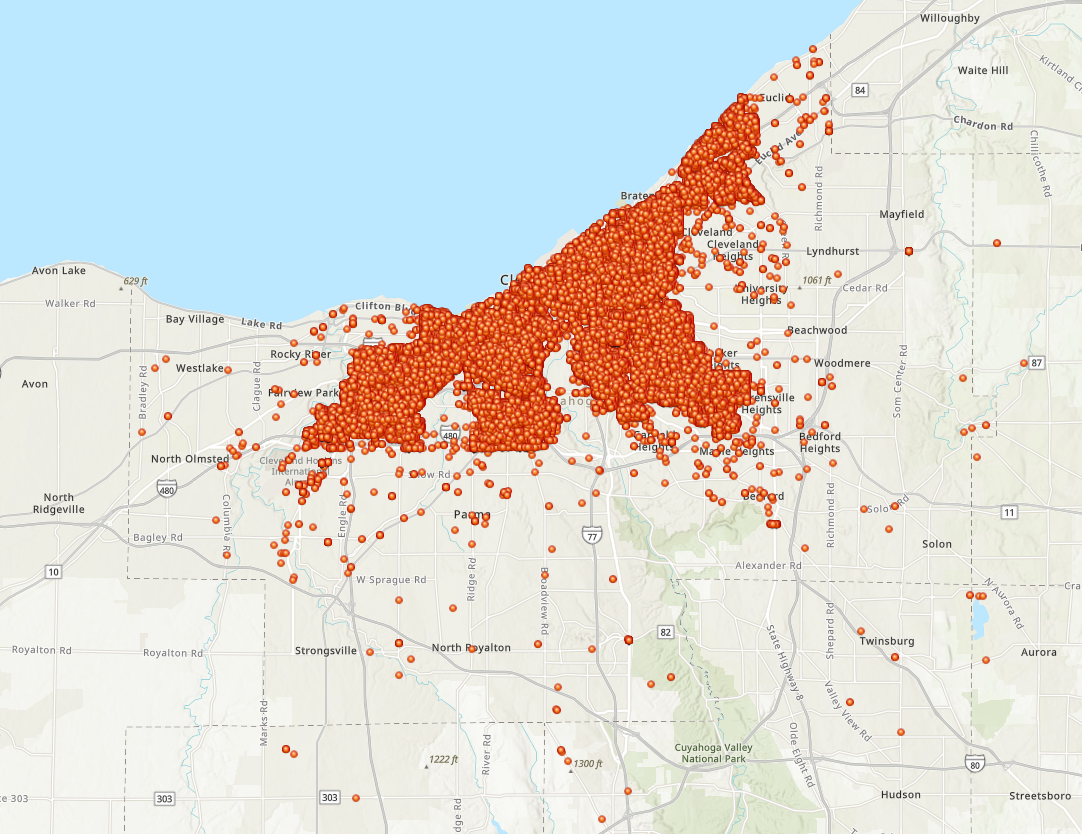

In [4]:
from IPython.display import Image
p1 = 'data\\total_crime_in_cleveland.png'
p2 = 'data\\violent_crime_in_cleveland.png'
# Display the image
Image(filename=p1)

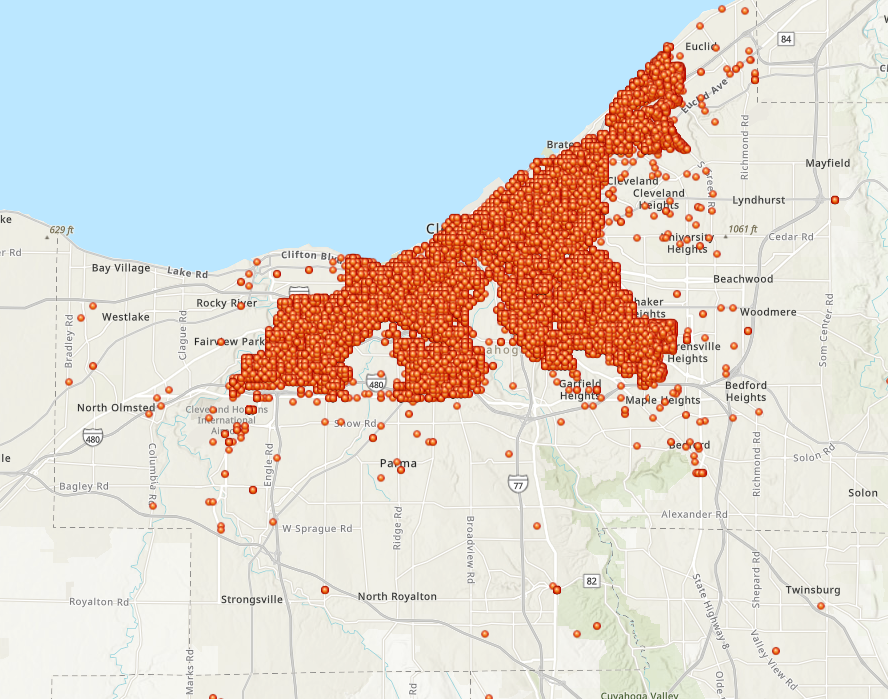

In [5]:
Image(filename=p2)

In [ ]:
crime_hot_spots = find_hot_spots(crime_sdf,
                                 output_name='Crime_Cleveland_Hotspots',
                                 bounding_polygon_layer=city_boundary)

In [ ]:
crime_hot_spots

## Part 4: Correlation Analysis